### Abitrary polarization correction
Relevant for FORT polarization optimization in the network experiment.

In [53]:
import numpy as np
from numpy import sin, cos, exp, pi, sqrt, trace, dot
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## definitions

In [277]:
# states defined in the basis {1,0} = {H,V}
V = np.array([0,1])
H = np.array([1,0])
D = np.array([1,1])/sqrt(2)
A = np.array([1,-1])/sqrt(2)
R = np.array([1,-1j])/sqrt(2)
L = np.array([1,1j])/sqrt(2)

# in the H,V basis
s0 = np.array([[1,0],[0,1]])
s1 = np.array([[0,1],[1,0]])
s2 = np.array([[0,-1j],[1j,0]])
s3 = np.array([[1,0],[0,-1]])

# we want to switch to the R,L basis, which is more common for drawing on the Poincaré sphere
projR = np.outer(R,np.conj(R))
evals, evecs = np.linalg.eig(projR)
U = evecs.transpose() # doesn't do anything in this case b.c. the matrix is symmetric about the diagonal
# U[:,[1,0]] = U[:,[0,1]] # I found it necessary to swap the columns
Uinv = np.linalg.inv(U)
assert np.isclose(trace(Uinv.dot(projR).dot(U)), np.sum(Uinv.dot(projR).dot(U))), "oops, matrix isn't diagonal" 

# in the R,L basis
s1 = Uinv.dot(s1).dot(U)
s2 = Uinv.dot(s2).dot(U)
s3 = Uinv.dot(s3).dot(U)

def poincare_sphere(ax=None):
    """
    plots the Poincare sphere and returns the associated Axes object ax.

    The Z axis is vertical, as is standard, with circular polarization at the Z poles, H/V along X, and D/A along Y.

    ax: an Axes object. if not provided, one will be created
    """
    
    # Create a sphere
    phi, theta = np.mgrid[0:2*np.pi:100j, 0:np.pi:50j]
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    
    if ax is None:
        fig = plt.figure(figsize=(8, 8),dpi=100)
        ax = fig.add_subplot(111, projection='3d')
    
    # Plotting the Poincaré sphere    
    ax.plot_surface(x, y, z, color='pink', alpha=0.3, rstride=1, cstride=1, linewidth=0)
    
    # Labeling the poles
    ax.text(0, 0, 1.1, 'R', color='black', fontsize=14, ha='center')
    ax.text(0, 0, -1.1, 'L', color='black', fontsize=14, ha='center')
    
    ax.text(1.1, 0, 0, 'V', color='black', fontsize=14, ha='center')
    ax.text(-1.1, 0, 0, 'H', color='black', fontsize=14, ha='center')
    
    ax.text(0, 1.1, 0, 'D', color='black', fontsize=14, ha='center')
    ax.text(0, -1.1, 0, 'A', color='black', fontsize=14, ha='center')
    
    # Draw axes
    # ax.quiver(0, 0, 0, 1.2, 0, 0, color='k', arrow_length_ratio=0.1)
    # ax.quiver(0, 0, 0, 0, 1.2, 0, color='k', arrow_length_ratio=0.1)
    # ax.quiver(0, 0, 0, 0, 0, 1.2, color='k', arrow_length_ratio=0.1)
    
    # Label axes
    # ax.text(1.2, 0, 0, 'S1', color='k', fontsize=14, ha='center')
    # ax.text(0, 1.2, 0, 'S2', color='k', fontsize=14, ha='center')
    # ax.text(0, 0, 1.2, 'S3', color='k', fontsize=14, ha='center')
    
    # Generate points for the equatorial circle
    theta = np.linspace(0, 2 * np.pi, 100)
    x_eq = np.cos(theta)
    y_eq = np.sin(theta)
    z_eq = np.zeros_like(theta)
    
    # Plot the equatorial circle
    ax.plot(x_eq, y_eq, z_eq, 'k--')  # 'k--' specifies a black dashed line
    
    # Generate points for the equatorial circle
    axis_pts = np.linspace(-1, 1, 100)
    ax.plot(axis_pts, np.zeros_like(axis_pts), np.zeros_like(axis_pts), 'k--')
    ax.plot(np.zeros_like(axis_pts), axis_pts, np.zeros_like(axis_pts), 'k--')
    ax.plot(np.zeros_like(axis_pts), np.zeros_like(axis_pts), axis_pts, 'k--')
    
    # Setting the aspect ratio
    ax.set_box_aspect([1,1,1])
    
    # Hide the axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    # Transparent spines
    ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    
    # Transparent panes
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_aspect('equal')
    
    return ax

def get_stokes_params(jones_vec):
    """
    compute the four Stokes parameters from a 2-element Jones vector
    """
    rho = np.outer(np.conj(jones_vec),jones_vec)
    S0 = trace(dot(s0,rho))
    S1 = trace(dot(s1,rho))
    S2 = trace(dot(s2,rho))
    S3 = trace(dot(s3,rho))
    
    return np.real(S0), np.real(S1), np.real(S2), np.real(S3)

def draw_stokes_vector(ax, jones_vec, color='k', label=''):
    """
    plot the 2-element complex jones vector on the supplied ax
    
    ax is presumed to be a 3D projection. 

    Note that the Stokes parameters S3, S2, and S1 used here are with respect to a basis {1,0} = {R,L}, which are
    are typically taken to be at the poles of, e.g. the Bloch sphere, or equivalently, along the S3 axis of the Poincare sphere. 
    However, unlike the typical convention, {H,V} is taken to be along S2 (Y) and {D,A} along S1 (X), which is unlike
    the typical convention. I did this because I found that those were the components of the respective states after transforming
    the Pauli matrices to the R,L basis. 
    
    return S0, S1, S2, S3
    """

    S0, S1, S2, S3 = get_stokes_params(jones_vec)
    
    ax.text(1.2*S2, 1.2*S1, 1.2*S3, label, color=color, fontsize=14, ha='center')
    ax.quiver(0, 0, 0, S2, S1, S3, color=color, arrow_length_ratio=0.1)

QWP0 = np.array([[1,0],[0,1j]]) # Fowles, vertically oriented fast axis
HWP0 = np.array([[1,0],[0,-1]]) # Fowles, vertically or horizontally oriented fast axis
Rmat = lambda theta: np.array([[cos(theta), sin(theta)],[-sin(theta),cos(theta)]])
Rmat_inv = lambda theta: np.linalg.inv(Rmat(theta))

QWP = lambda theta: np.dot(np.dot(Rmat(theta), QWP0), Rmat_inv(theta)) # quarter-wave plate, theta wrt vertical
HWP = lambda theta: np.dot(np.dot(Rmat(theta), HWP0), Rmat_inv(theta)) # half-wave plate, theta wrt vertical

# arbitrarty-wave plate: can be any unitary transformation - not yet checked
AWP = lambda theta, phi, eta: exp(-1j*eta/2)*np.array([[cos(theta)**2+exp(1j*eta)*sin(theta)**2, (1-exp(1j*eta))*exp(-1j*phi)*cos(theta)*sin(theta)],
                                                       [(1-exp(1j*eta))*exp(1j*phi)*cos(theta)*sin(theta), exp(1j*eta)*cos(theta)**2+sin(theta)**2]])

## waveplate rotations on Poincaré sphere

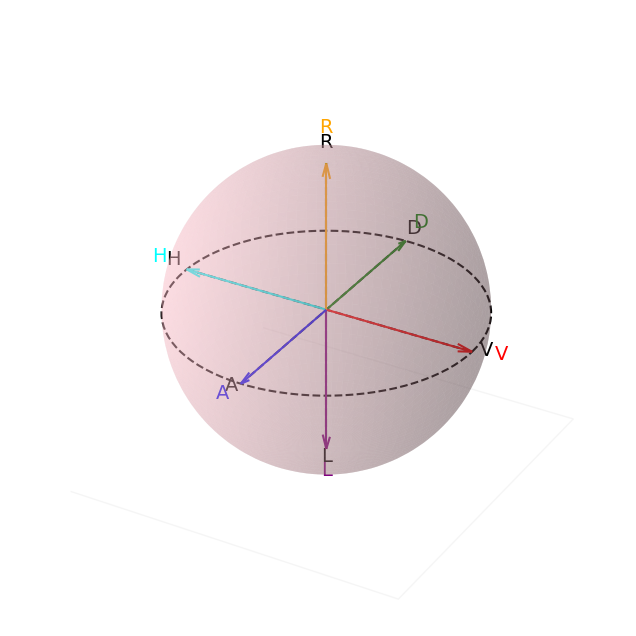

In [279]:
# plot the different basis states
ax = poincare_sphere()
for u, color, lbl in zip([V,H,D,A,R,L], ['red','cyan','green','blue','orange','purple'], ['V','H','D','A','R','L']):
    draw_stokes_vector(ax, u, color=color, label=lbl)

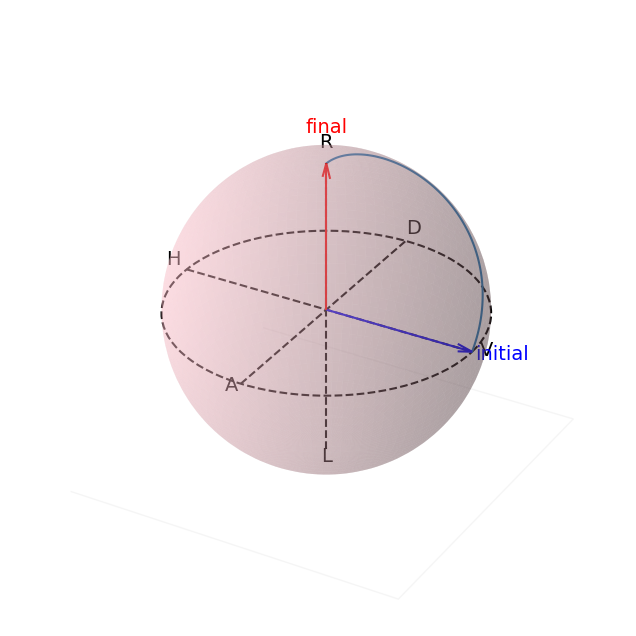

In [280]:
# plot the action of a quarter waveplate
ax = poincare_sphere()

theta_0=0
theta_f=pi/4
theta_pts = np.linspace(theta_0,theta_f,100)
_, s1_pts, s2_pts, s3_pts = np.transpose(np.array([get_stokes_params(dot(QWP(theta),V)) for theta in theta_pts]))

draw_stokes_vector(ax, dot(QWP(theta_0),V), color='blue', label='initial')
ax.plot(s2_pts, s1_pts, s3_pts)
draw_stokes_vector(ax, dot(QWP(theta_f),V), color='red', label='final')

ax.set_aspect('equal')
# draw_stokes_vector(ax, u, color=color, label=lbl)

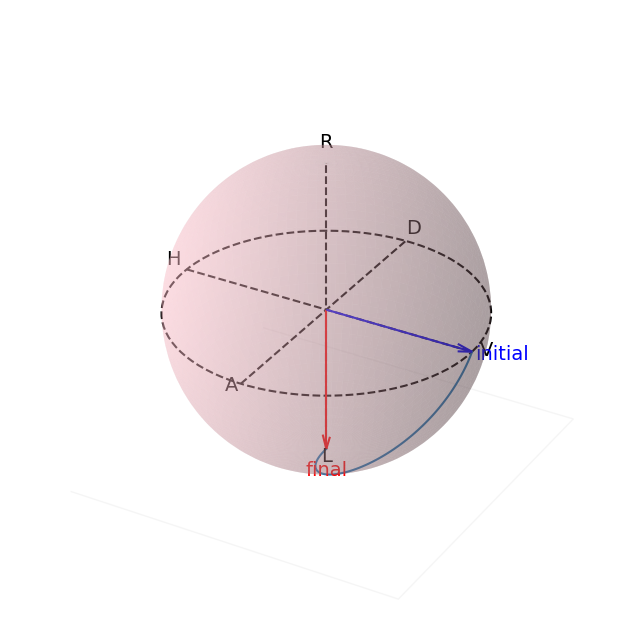

In [281]:
# plot the action of a quarter waveplate
ax = poincare_sphere()

theta_0=0
theta_f=-pi/4
theta_pts = np.linspace(theta_0,theta_f,100)
_, s1_pts, s2_pts, s3_pts = np.transpose(np.array([get_stokes_params(dot(QWP(theta),V)) for theta in theta_pts]))

draw_stokes_vector(ax, dot(QWP(theta_0),V), color='blue', label='initial')
ax.plot(s2_pts, s1_pts, s3_pts)
draw_stokes_vector(ax, dot(QWP(theta_f),V), color='red', label='final')

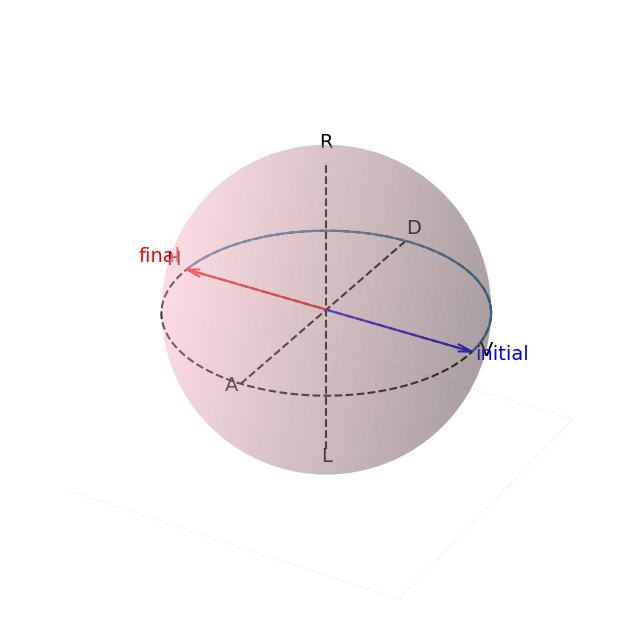

In [283]:
# plot the action of a half waveplate
ax = poincare_sphere()

theta_0=0
theta_f=pi/4
theta_pts = np.linspace(theta_0,theta_f,100)
_, s1_pts, s2_pts, s3_pts = np.transpose(np.array([get_stokes_params(dot(HWP(theta),V)) for theta in theta_pts]))

draw_stokes_vector(ax, dot(HWP(theta_0),V), color='blue', label='initial')
ax.plot(s2_pts, s1_pts, s3_pts)
draw_stokes_vector(ax, dot(HWP(theta_f),V), color='red', label='final')

## testing

In [4]:
HWP(0), HWP(pi/4), QWP(0), QWP(-pi/4)

(array([[ 1.,  0.],
        [ 0., -1.]]),
 array([[ 6.123234e-17,  1.000000e+00],
        [ 1.000000e+00, -6.123234e-17]]),
 array([[1.000000e+00+0.j, 0.000000e+00+0.j],
        [0.000000e+00+0.j, 6.123234e-17-1.j]]),
 array([[ 1.+0.0000000e+00j, -0.-1.0000000e+00j],
        [-0.-1.0000000e+00j, -1.-1.2246468e-16j]]))

In [214]:
dot(QWP(0),V), dot(QWP(pi/4),V)

(array([0.000000e+00+0.j, 6.123234e-17-1.j]), array([0.+1.j, 1.+0.j]))

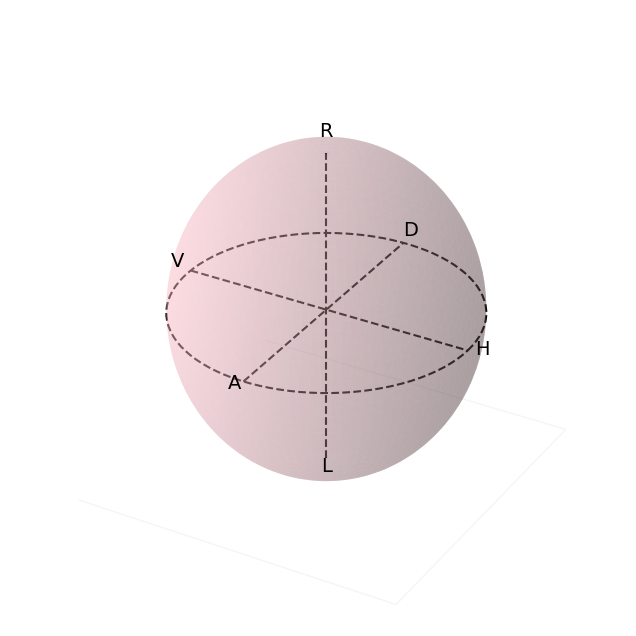

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ax = poincare_sphere()

ax.plot()

In [171]:
V = np.array([0,1])
H = np.array([1,0])
D = np.array([1,1])/sqrt(2)
A = np.array([1,-1])/sqrt(2)
R = np.array([1,-1j])/sqrt(2)
L = np.array([1,1j])/sqrt(2)

In [162]:
for u in [V,H,D,A,R,L]:
    print(np.dot(np.conj(u),u))

1
1
0.9999999999999998
0.9999999999999998
(0.9999999999999998+0j)
(0.9999999999999998+0j)


In [163]:
for u in [V,H,D,A,R,L]:
    print(np.outer(u,np.conj(u)))

[[0 0]
 [0 1]]
[[1 0]
 [0 0]]
[[0.5 0.5]
 [0.5 0.5]]
[[ 0.5 -0.5]
 [-0.5  0.5]]
[[0.5+0.j  0. -0.5j]
 [0. +0.5j 0.5+0.j ]]
[[ 0.5+0.j  -0. +0.5j]
 [-0. -0.5j  0.5+0.j ]]


In [175]:
projR = np.outer(R,np.conj(R))
print(projR)

evals, evecs = np.linalg.eig(projR)
print(evecs)

U = evecs.transpose()
U[:,[1,0]] = U[:,[0,1]]
Uinv = np.linalg.inv(U)
Uinv.dot(projR).dot(U)

[[ 0.5+0.j  -0. +0.5j]
 [-0. -0.5j  0.5+0.j ]]
[[-0.        +0.70710678j  0.70710678+0.j        ]
 [ 0.70710678+0.j         -0.        +0.70710678j]]


array([[3.08839715e-32+0.00000000e+00j, 0.00000000e+00+2.68031548e-16j],
       [0.00000000e+00-1.67155782e-16j, 1.00000000e+00+0.00000000e+00j]])

V: S0=1, S1=1.0146536357569526e-17j, S2=(-1+0j), S3=(-3.133961632045815e-16+0j)
H: S0=1, S1=6.835808657661918e-17j, S2=(1+0j), S3=(3.8920038715097833e-16+0j)
D: S0=0.9999999999999998, S1=(0.9999999999999998+3.925231146709435e-17j), S2=-5.686135072515376e-17j, S3=(3.790211197319839e-17+0j)
A: S0=0.9999999999999998, S1=(-0.9999999999999998+3.925231146709435e-17j), S2=5.686135072515376e-17j, S3=(3.790211197319839e-17+0j)
R: S0=(0.9999999999999998+0j), S1=1.1102230246251565e-16j, S2=(3.885780586188048e-16+0j), S3=(-0.9999999999999997+0j)
L: S0=(0.9999999999999998+0j), S1=0j, S2=(-3.3306690738754696e-16+0j), S3=(0.9999999999999998+0j)


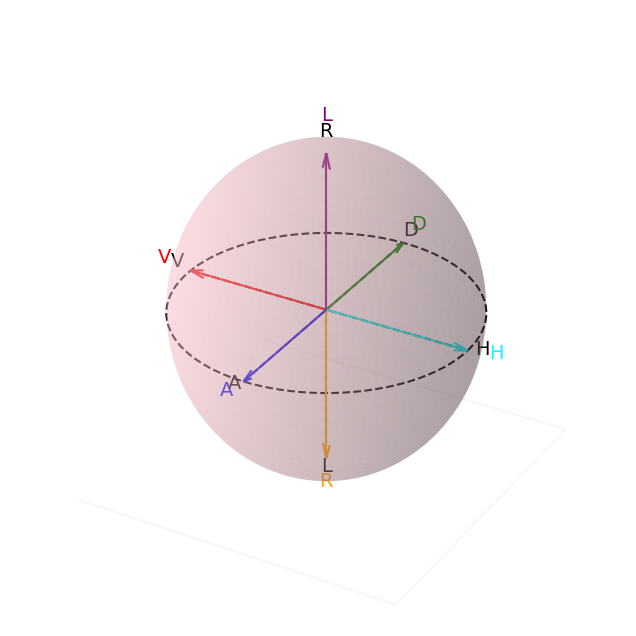

In [180]:
# in the H,V basis
s0 = np.array([[1,0],[0,1]])
s1 = np.array([[0,1],[1,0]])
s2 = np.array([[0,-1j],[1j,0]])
s3 = np.array([[1,0],[0,-1]])

# in the R,L basis
s1 = Uinv.dot(s1).dot(U)
s2 = Uinv.dot(s2).dot(U)
s3 = Uinv.dot(s3).dot(U)

ax = poincare_sphere()

for u, color, lbl in zip([V,H,D,A,R,L], ['red','cyan','green','blue','orange','purple'], ['V','H','D','A','R','L']):
    # rho = np.outer(u,np.conj(u))
    # S0 = trace(dot(s0,rho))
    # S1 = trace(dot(s1,rho))
    # S2 = trace(dot(s2,rho))
    # S3 = trace(dot(s3,rho))
    
    # print(f"{lbl}: S0={np.real(S0):.2f}, S1={np.real(S1):.2f}, S2={np.real(S2):.2f}, S3={np.real(S3):.2f}")

    # print(sqrt(S1**2+S2**2+S3**2)/S0**2)
    
    # ax.text(1.2*S1, 1.2*S2, 1.2*S3, lbl, color=color, fontsize=14, ha='center')
    # ax.quiver(0, 0, 0, S1, S2, S3, color=color, arrow_length_ratio=0.1)

    draw_stokes_vector(ax, u, color=color, label=lbl)

In [151]:
u = V
rho = np.outer(np.conj(u),u)
trace(dot(s1,rho))

-1.0146536357569551e-17j

In [63]:
dot(s1,rho)

array([[0, 1],
       [0, 0]])

In [65]:
s1 = np.outer(np.conj(D),D)
s2 = np.outer(np.conj(R),R)
s3 = np.outer(np.conj(H),H)

s1, s2, s3

(array([[0.5, 0.5],
        [0.5, 0.5]]),
 array([[ 0.5+0.j , -0. -0.5j],
        [-0. +0.5j,  0.5+0.j ]]),
 array([[1, 0],
        [0, 0]]))